In [ ]:
'''
LDA implementation using gensim
note: much of the code is derived from the pipeline
of priya dwivedi https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb
Collaborators: DeAndre Tomlinson, Emmet Flynn, Paul Brunts
'''

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
import os
import logging
import seaborn as sns
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'https', 'high', 'time', 
                    'table', 'read', 'number', 'also', 'show', 'elsevi'
                  ])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dtomlins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Functions:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [4]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [5]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [6]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
def stemWords(texts):
    ps = PorterStemmer()
    stemmed = [[ps.stem(word) for word in text] for text in texts]
    return stemmed

In [9]:
#!!data is trainingData!!
data=[]
testingData=[]
trainingNameList=[]
testingNameList=[]
positiveNameList=[]
trainingLabelList=[]
testingLabelList=[]
#Number of topics
kTopics=3
#let's load in the names of the files as names,
#and see if it matches up to the names of the files
#should be in the same order
for filename in os.listdir('positiveTextFiles'):
    positiveNameList.append(filename)

In [10]:
for filename in os.listdir('trainingFiles'):
    trainingNameList.append(filename)
    filePath='trainingFiles/'+filename
    with open(filePath, 'r') as file:
        x=file.read()
        data.append(x)
        trainingLabelList.append(1 if filename in positiveNameList else 0)

for filename in os.listdir('testingFiles'):
    testingNameList.append(filename)
    filePath='testingFiles/'+filename
    with open(filePath, 'r') as file:
        x=file.read()
        testingData.append(x)
        testingLabelList.append(1 if filename not in positiveNameList else 0)

In [11]:
#BIGRAMS AND TRIGRAMS DO NOT WORK. UNIGRAM ONLY.
#not entirely sure about nthreshold
# Build the bigram and trigram models
#nthreshold=100
#bigram = gensim.models.Phrases(data_words, min_count=5, threshold=nthreshold) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=nthreshold)  

# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
#Input is an empty list
def dataCleaning(data):
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'", "", sent) for sent in data]
    #remove words less than 4 characters
    data = [re.sub(r'\b\w{1,3}\b', '', sent) for sent in data]
    # Remove Stop Words
    data = remove_stopwords(data)


    # Lemmatization keeping only noun, adj, vb 
    data = lemmatization(data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    #Stem words
    data = stemWords(data)

    data_cleaned = data
    return(data_cleaned)

trainD = dataCleaning(data)

In [13]:
trainDwords = list(sent_to_words(trainD))
trainDwords

[['viru',
  'bacteria',
  'microeukaryot',
  'viru',
  'bacteria',
  'microeukaryot',
  'suttl',
  'contribut',
  'equal',
  'correspond',
  'author',
  'depart',
  'microbiolog',
  'address',
  'essenti',
  'resourc',
  'increas',
  'valu',
  'clean',
  'water',
  'sourc',
  'diminish',
  'microorgan',
  'river',
  'major',
  'sourc',
  'renew',
  'freshwat',
  'signific',
  'role',
  'drink',
  'water',
  'safeti',
  'signal',
  'environment',
  'contamin',
  'drive',
  'global',
  'nutrient',
  'cycl',
  'howev',
  'foundat',
  'understand',
  'microbi',
  'commun',
  'river',
  'lack',
  'especi',
  'tempor',
  'viru',
  'studi',
  'date',
  'examin',
  'composit',
  'free',
  'float',
  'river',
  'virom',
  'explan',
  'underli',
  'caus',
  'spatial',
  'tempor',
  'chang',
  'riverin',
  'microbi',
  'composit',
  'especi',
  'viru',
  'remain',
  'unexplor',
  'report',
  'relationship',
  'riverin',
  'microbi',
  'commun',
  'environ',
  'space',
  'superkingdom',
  'viru',


In [54]:
def wordsPreAnalysis(data):
    words_list = [j for sub in data for j in sub]
    freqwords = nltk.FreqDist(words_list)
    words_df = pd.DataFrame({'word':list(freqwords.keys()), 'count':list(freqwords.values())})
    return(freqwords, words_df)

def wordsFilter(data):
    words_list = [j for sub in data for j in sub]
    wordfilter = ['elsevi']
    filtered_words = [word for word in words_list if word not in wordfilter]
    return(filtered_words)

In [62]:
def wordsFilter2(data):
    # using list comprehension + list slicing 
    # Removing element from list of lists 
    wordfilter = ['elsevi']
    for sub in data: 
        sub[:] = [ele for ele in sub if ele not in wordfilter] 
    return(data)

In [68]:
freqwords, words_df = wordsPreAnalysis(trainD)
filt_words = wordsFilter2(trainD)
filt_Dwords = list(sent_to_words(filt_words))

In [63]:
#testing filter words function
filt_tester = wordsFilter2(trainD)

filt_Dwtester = list(sent_to_words(filt_tester))
filt_Dwtester

len(filt_Dwtester)

In [114]:
#freqwords.plot(20)
dflist = words_df.sort_values(by=["count"], ascending=False)
dflist[dflist["count"]<5]

,word,count
2169,eucaryot,4
5531,mep,4
4373,struction,4
5211,ularli,4
1752,financ,4
...,...,...
7434,exopolymer,1
7432,hovelsrud,1
7431,mei,1
7430,emeri,1


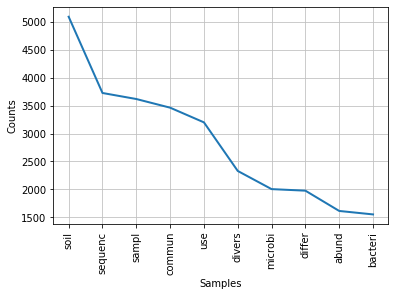

In [17]:
filt_freqwords = nltk.FreqDist(filt_words)
filt_freqwords.plot(10)

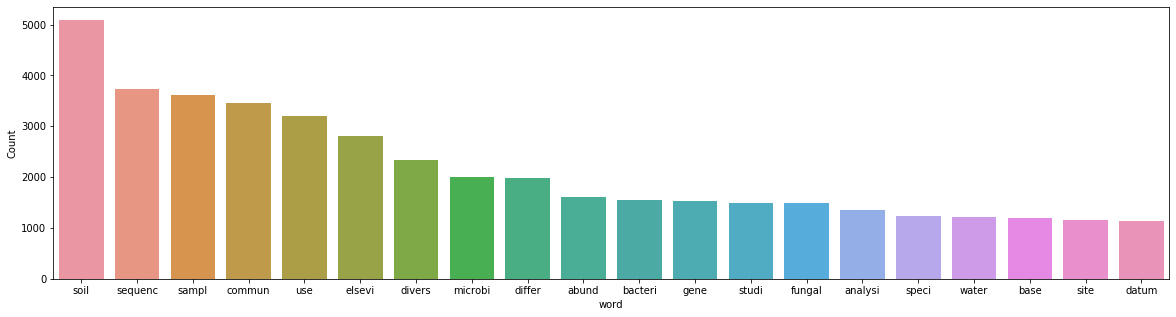

In [18]:
# selecting top 20 most frequent words
d = words_df.nlargest(columns="count", n = 20) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
plt.show()


In [69]:
def createDict(words, freq):
    # Create Dictionary
    id2word = corpora.Dictionary(words)
    id2word.filter_extremes(no_below = freq)
    # Term Document Frequency
    corpus = [id2word.doc2bow(word) for word in words]
    return(id2word, corpus)

id2word, corpus = createDict(filt_Dwords, 5)

In [70]:
#ldamodel
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=kTopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
lda_model.save('cneoformans_3kmodel')
lda_model.show_topics()

[(0,
  '0.008*"substrat" + 0.008*"degrad" + 0.007*"warm" + 0.006*"litter" + 0.006*"fish" + 0.006*"sediment" + 0.006*"manur" + 0.006*"bottl" + 0.005*"climat" + 0.005*"contamin"'),
 (1,
  '0.017*"viru" + 0.013*"crop" + 0.010*"fertil" + 0.009*"viral" + 0.008*"protein" + 0.008*"wheat" + 0.007*"prokaryot" + 0.007*"degrad" + 0.007*"funder" + 0.007*"licens"'),
 (2,
  '0.012*"refhub" + 0.011*"protist" + 0.007*"fraction" + 0.006*"ocean" + 0.006*"island" + 0.005*"seedl" + 0.005*"aggreg" + 0.005*"miner" + 0.005*"clade" + 0.005*"diatom"')]

In [102]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_list[2], texts=filt_Dwords, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3888775515043133


In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
        Compute c_v coherence for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        perplexity_values
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [73]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=trainDwords, start=2, limit=10, step=1)

In [104]:
model_list[2].save('cneoformans_4kmodel')

Num Topics = 2 has a Coherence Value of  0.3054  and has Perplexity Value of 1440.1163
Num Topics = 3 has a Coherence Value of  0.2949  and has Perplexity Value of 1380.142
Num Topics = 4 has a Coherence Value of  0.4008  and has Perplexity Value of 1292.8527
Num Topics = 5 has a Coherence Value of  0.4065  and has Perplexity Value of 1274.1948
Num Topics = 6 has a Coherence Value of  0.3998  and has Perplexity Value of 1243.205
Num Topics = 7 has a Coherence Value of  0.3726  and has Perplexity Value of 1212.2769
Num Topics = 8 has a Coherence Value of  0.3756  and has Perplexity Value of 1220.3867
Num Topics = 9 has a Coherence Value of  0.3709  and has Perplexity Value of 1212.2278


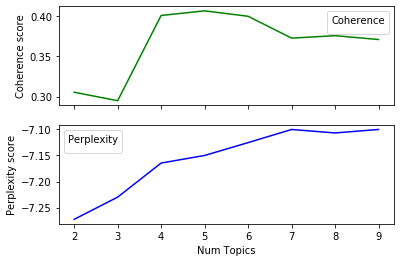

In [74]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
fig, axs = plt.subplots(2,1, sharex=True)
plt.xlabel("Num Topics")
axs[0].plot(x, coherence_values, color='green')


#axs[0].set_xlabel("Num Topics")
axs[0].set_ylabel("Coherence score")
axs[0].legend(title ="Coherence", loc='best')
#axs[0].savefig("chose_model.png")

axs[1].plot(x, perplexity_values, color='blue')
#axs[1].set_xlabel("Num Topics")
axs[1].set_ylabel("Perplexity score")
axs[1].legend(title="Perplexity", loc='best')
# Print the coherence scores
for m, cv, pv in zip(x, coherence_values, perplexity_values):
        print("Num Topics =", m, "has a Coherence Value of ", round(cv, 4), " and has Perplexity Value of", round(np.exp(-1. * pv), 4))

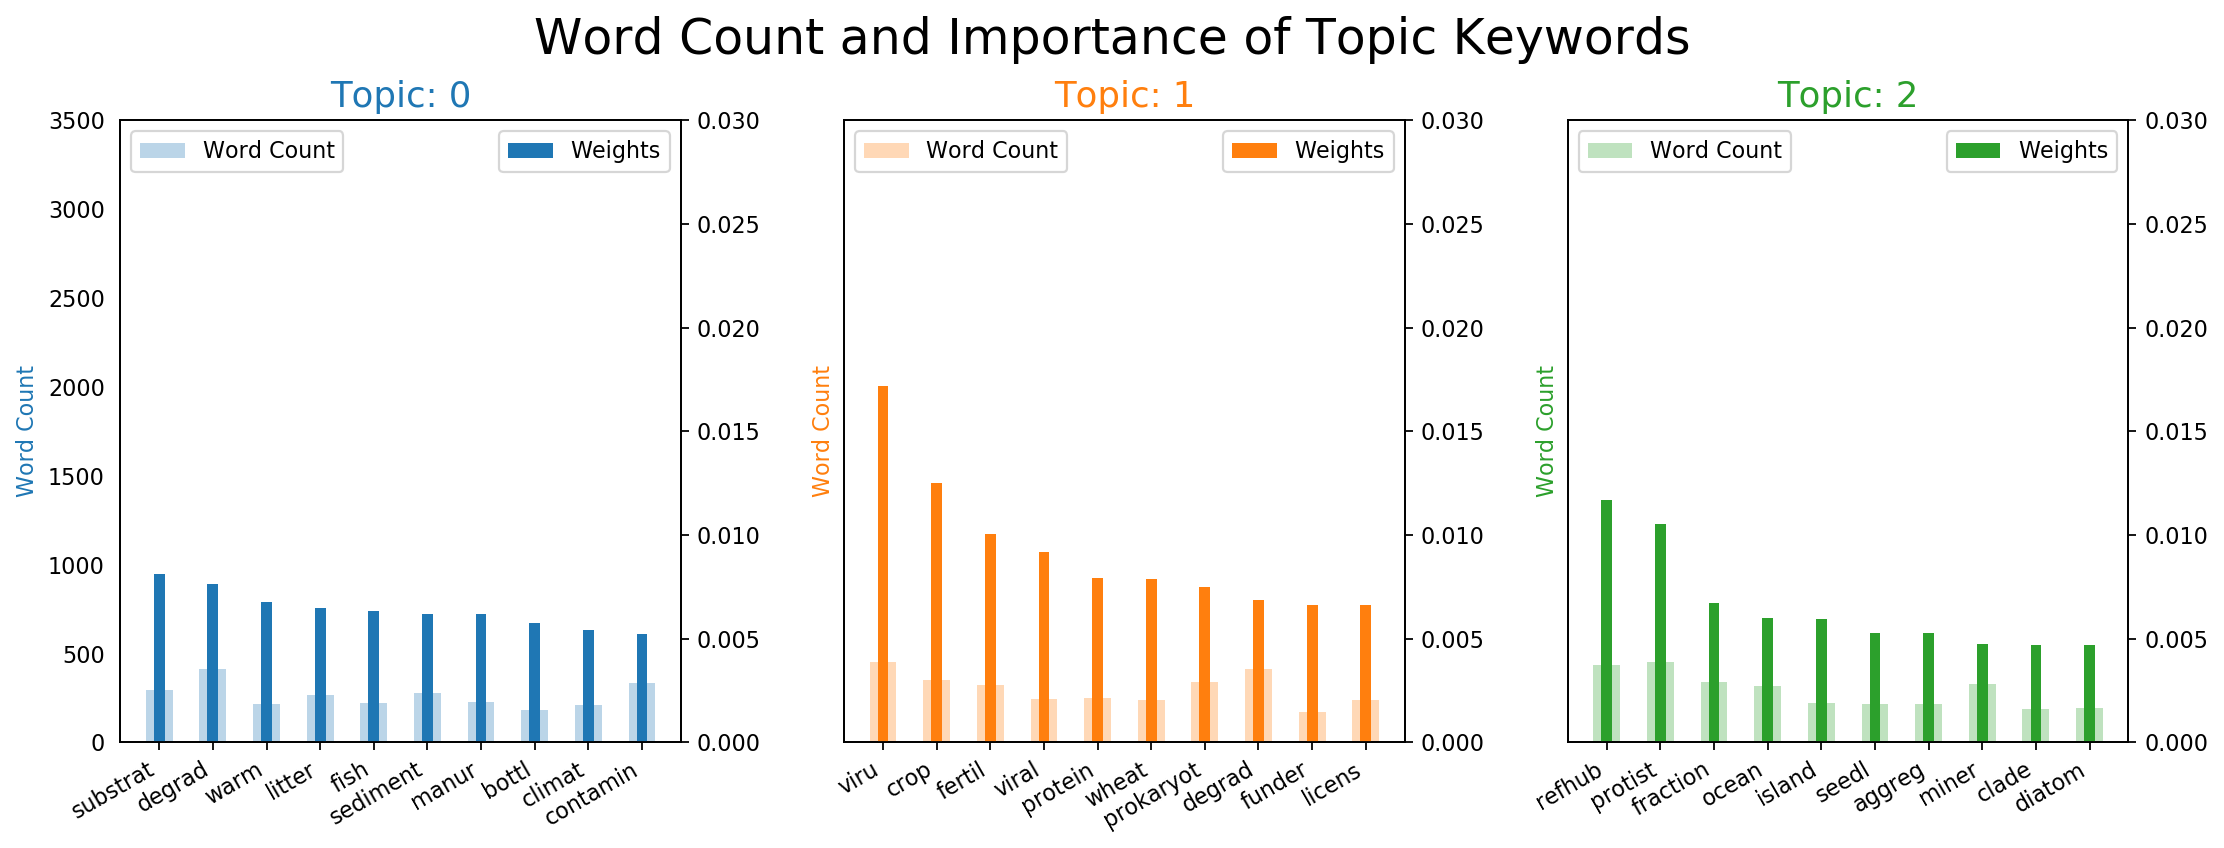

In [81]:
from collections import Counter
import matplotlib.colors as mcolors
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in filt_Dwords for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [100]:
import pyLDAvis
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model_list[2], corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [106]:
pyLDAvis.save_html(lda_display, 'lda_4k_vis.html')

#Processing for testing corpus

In [105]:
testD = dataCleaning(testingData)
testDwords = list(sent_to_words(testD))

In [107]:
freqTestwords, wordsTestdf = wordsPreAnalysis(testDwords)


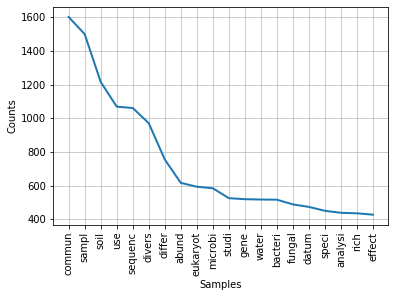

In [108]:
freqTestwords.plot(20)

In [118]:
dflist = wordsTestdf.sort_values(by=["count"], ascending=False)
dflist[dflist["count"] < 5].head(30)

,word,count
1404,breadth,4
5018,decontamin,4
5023,conidia,4
3705,ganism,4
1914,touch,4
3704,microor,4
2051,thermoclin,4
539,ideal,4
2032,mett,4
5045,glycerol,4


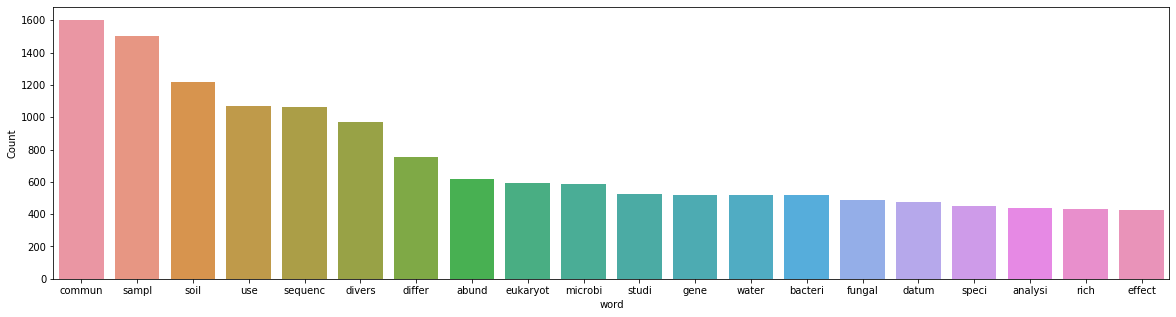

In [119]:
# selecting top 20 most frequent words
d = wordsTestdf.nlargest(columns="count", n = 20) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
plt.show()

In [120]:
id2wordTest, corpusTest = createDict(testDwords, 5)

In [31]:
def format_topics_sentences_v2(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    series_list=[]
    for i in range(kTopics):
        series_list.append(0)
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            wp = ldamodel.show_topic(topic_num)
            series_list[topic_num]=prop_topic
            #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        sent_topics_df=sent_topics_df.append(pd.Series([series_list[i] for i in range(len(series_list))]), ignore_index=True)

    
    #sent_topics_df.columns = ['Topic_0', 'Topic_1', 'Topic_2']
    # Add original text to the end of the output
    #contents = pd.Series(texts, index='contents')
    sent_topics_df['contents'] = texts
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [125]:
def topicProbs2csv(df, labelList, nameList, filename):
    df['label'] = labelList
    df['name'] = nameList
    
    # Show
    names = ['topic_{}'.format(i) for i in range(len(df.columns.values.tolist()) - 3)]+['contents', 'label', 'name'] 
    df.columns = names
    
    # Below we pull into the csv only the columns associated with the topics
    # and the labels. (this is the first kTopics columns and the second column
    # from the end
    csv = df[names[:kTopics]+[names[-2]]].copy().to_csv(filename, index=False)
    csv_printout = df[names[:kTopics]+[names[-2]]].copy().to_csv(index=False)
    #print(csv_printout)


In [85]:
df_topic_sents_keywords = format_topics_sentences_v2(lda_model, corpus, filt_Dwords)

In [121]:
df_testing_topic_keywords = format_topics_sentences_v2(lda_model, corpusTest, testDwords)

In [126]:
testCsvfile = 'ltg_3k_testing.csv'
testCsv = topicProbs2csv(df_testing_topic_keywords, testingLabelList, testingNameList, testCsvfile)

In [127]:
trainCsvfile = 'ltg_3k_training.csv'
trainCsv = topicProbs2csv(df_topic_sents_keywords, trainingLabelList, trainingNameList, trainCsvfile)

In [130]:
kTopics = 4
df_4test_topkeywords = format_topics_sentences_v2(model_list[2], corpusTest, testDwords)
df_4train_topkeywords = format_topics_sentences_v2(model_list[2], corpus, filt_Dwords)

In [131]:
testCsvfile = 'ltg_4k_testing.csv'
testCsv = topicProbs2csv(df_4test_topkeywords, testingLabelList, testingNameList, testCsvfile)
trainCsvfile = 'ltg_4k_training.csv'
trainCsv = topicProbs2csv(df_4train_topkeywords, trainingLabelList, trainingNameList, trainCsvfile)

In [ ]:
#print(lda_model[id2word.doc2bow(data_lemmatized[5])])
df_topic_sents_keywords = format_topics_sentences_v2(lda_model, corpus, data)
df_topic_sents_keywords['label'] = trainingLabelList
df_topic_sents_keywords['name'] = trainingNameList

df_testing_topics = format_topics_sentences_v2(lda_model, testing_corpus, testingData)
df_testing_topics['label'] = testingLabelList
df_testing_topics['name'] = testingNameList
# Format
#df_dominant_topic = df_topic_sents_keywords.reset_index()
#df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
names = ['topic_{}'.format(i) for i in range(len(df_topic_sents_keywords.columns.values.tolist()) - 3)]+['contents', 'label', 'name'] 
df_topic_sents_keywords.columns = names
df_testing_topics.columns = names

# Below we pull into the csv only the columns associated with the topics
# and the labels. (this is the first kTopics columns and the second column
# from the end
csv = df_topic_sents_keywords[names[:kTopics]+[names[-2]]].copy().to_csv()
testing_csv = df_testing_topics[names[:kTopics]+[names[-2]]].copy().to_csv()

For printing the dataframes
print(df_topic_sents_keywords) #these are the topics mapped to the documents #it is a pandas dataframe
print(df_testing_topics) #these are the topics mapped to the documents #it is a pandas dataframe

In [ ]:
#LDAMallet stuff
mallet_path = "/home/deandret/school-projects/Cryptococcus-neoformans-Search-and-Destroy/mallet-2.0.8/bin/mallet"

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        
        else:
            break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
'''
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
trainDwords_vec = vectorizer.fit_transform(filt_words)

GRID SEARCH TAKES TOO LONG, BUT WOULD BE GREAT TO IMPLEMENT
# Define Search Param
search_params = {'n_components': [1,2,3]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

model.fit(trainDwords_vec)

# Best Model
#best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))
'''